# ATP tennis dataset

In [1]:
%matplotlib inline

In [2]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np

from datetime import datetime, timezone
from kseval.models import iterate_dataset
from kseval.models.tennis import EloModel, TrueSkillModel, DATASET
from kseval.utils import data_path
from math import log

## Summary statistics

In [3]:
counter = collections.Counter()
n_obs = 0
for obs in iterate_dataset(DATASET):
    counter[obs["winner"]] += 1
    counter[obs["loser"]] += 1
    n_obs += 1

In [4]:
print("number of observations: {:,}".format(n_obs))
print("number of players:      {:,}".format(len(counter)))

number of observations: 618,934
number of players:      20,046


Text(0.5, 0, 'player ID')

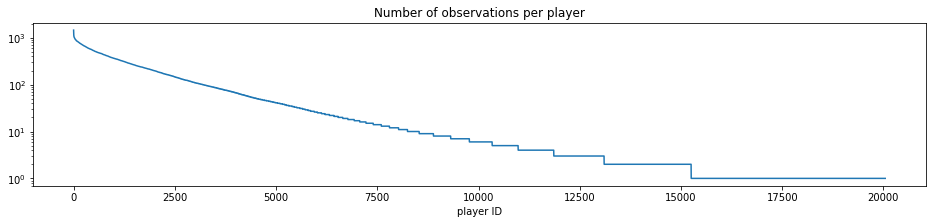

In [5]:
fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.semilogy(sorted(counter.values(), reverse=True))
ax.set_title("Number of observations per player")
ax.set_xlabel("player ID")

In [6]:
counter = collections.Counter()
ts = list()
for obs in iterate_dataset(DATASET):
    dt = datetime.fromtimestamp(obs["t"], tz=timezone.utc)
    counter[dt.year] += 1
    ts.append(obs["t"])

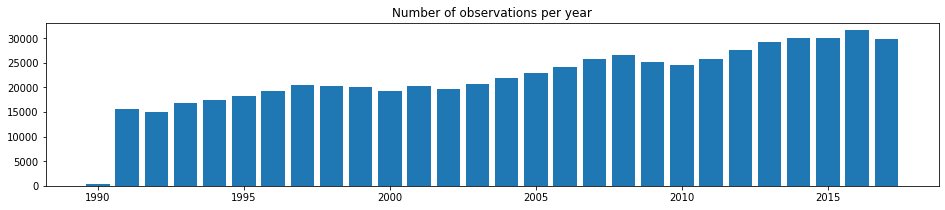

In [7]:
begin, end = min(counter), max(counter)
indices = np.arange(begin, end + 1, dtype=int)
counts = [counter[y] for y in indices]

fig, ax = plt.subplots(figsize=(16.0, 3.0))
ax.bar(indices, counts)
ax.set_title("Number of observations per year");

In [8]:
idx = int(0.7 * len(ts))
dt = datetime.fromtimestamp(ts[idx], tz=timezone.utc)
CUTOFF = datetime(dt.year, dt.month, dt.day, tzinfo=timezone.utc)

print("cutoff date: {:%Y-%m-%d}".format(CUTOFF))

cutoff date: 2011-08-28


## Evaluation of models

Elo

In [9]:
%%time
model = EloModel(lr=0.262)
model.fit(cutoff=CUTOFF)
elo = model.evaluate(begin=CUTOFF)

CPU times: user 7.63 s, sys: 55.6 ms, total: 7.68 s
Wall time: 7.68 s


TrueSkill

In [10]:
%%time
model = TrueSkillModel(sigma=0.3701, tau=0.0808)
model.fit(cutoff=CUTOFF)
trueskill = model.evaluate(begin=CUTOFF)

CPU times: user 3min 54s, sys: 232 ms, total: 3min 55s
Wall time: 3min 55s


In [11]:
res = {"random": {
    "n_obs": 0,
    "avg_ll": log(2),
    "avg_acc": 1/2
}}

for model, x in (("elo", elo), ("trueskill", trueskill)):
    res[model] = {
        "n_obs": x[0],
        "avg_ll": x[1] / x[0],
        "avg_acc": x[2] / x[0],
    }

for model in ("constant", "matern12", "matern32", "matern52",
        "ttt", "wiener", "affine-dyn", "affine-wiener", "kl"):
    n_obs, log_loss, accuracy = 0, 0.0, 0.0
    for datum in iterate_dataset("eval/tennis-{}.txt".format(model)):
        n_obs += datum["n_obs"]
        log_loss += datum["log_loss"]
        accuracy += datum["accuracy"]
    res[model] = {
        "n_obs": n_obs,
        "avg_ll": log_loss / n_obs,
        "avg_acc": accuracy / n_obs,
    }

# Save results for plots.
with open(data_path("fig/tennis-perf.json"), "w") as f:
    json.dump(res, f)

    with open(data_path("fig/tennis-perf.json")) as f:
        res = json.load(f)

### Results for dynamics

In [12]:
print("model            # obs  avg. ll  avg. acc")
print("-----------------------------------------")
fmt = "{: <13}   {: >6}    {:.3f}      {:.3f}"

for model in ("random", "elo", "trueskill", "constant", "matern12", "matern32",
        "matern52", "ttt", "wiener", "affine-dyn", "affine-wiener"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model            # obs  avg. ll  avg. acc
-----------------------------------------
random               0    0.693      0.500
elo             186361    0.563      0.705
trueskill       186361    0.563      0.705
constant        186361    0.581      0.689
matern12        186361    0.555      0.711
matern32        186361    0.556      0.710
matern52        186361    0.556      0.710
ttt             186361    0.554      0.712
wiener          186361    0.552      0.714
affine-dyn      186361    0.555      0.714
affine-wiener   186361    0.552      0.714


Best model:

- in terms of marginal log-likelihood: Affine + Wiener
- in terms of predictive log-loss: Wiener

### Results for variational objective

In [13]:
print("model            # obs  avg. ll  avg. acc")
print("-----------------------------------------")
fmt = "{: <13}   {: >6}    {:.4f}      {:.4f}"

for model in ("random", "affine-wiener", "kl"):
    r = res[model]
    print(fmt.format(model, r["n_obs"], r["avg_ll"], r["avg_acc"]))

model            # obs  avg. ll  avg. acc
-----------------------------------------
random               0    0.6931      0.5000
affine-wiener   186361    0.5520      0.7140
kl              186361    0.5521      0.7139
